## Data Exploration
Computing the feature importances using the XGBoost algorithm

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
all_chunks = pd.DataFrame()
with open('data/msddata_1000chunks.pkl', 'rb') as dataFile:
    all_chunks = pickle.load(dataFile)
print('Original data', all_chunks.shape)

Original data (1000000, 33)


In [3]:
# Filter Columns
train_data = all_chunks.dropna(subset=['tempo', 'artist_familiarity', 'mode', 'loudness', 'artist_hotttnesss', 'key_confidence', 'end_of_fade_in', 'start_of_fade_out', 'duration', 'time_signature', 'key', 'song_hotttnesss'])
train_data = train_data[train_data.song_hotttnesss != 0]
print(train_data.shape)    

(457194, 33)


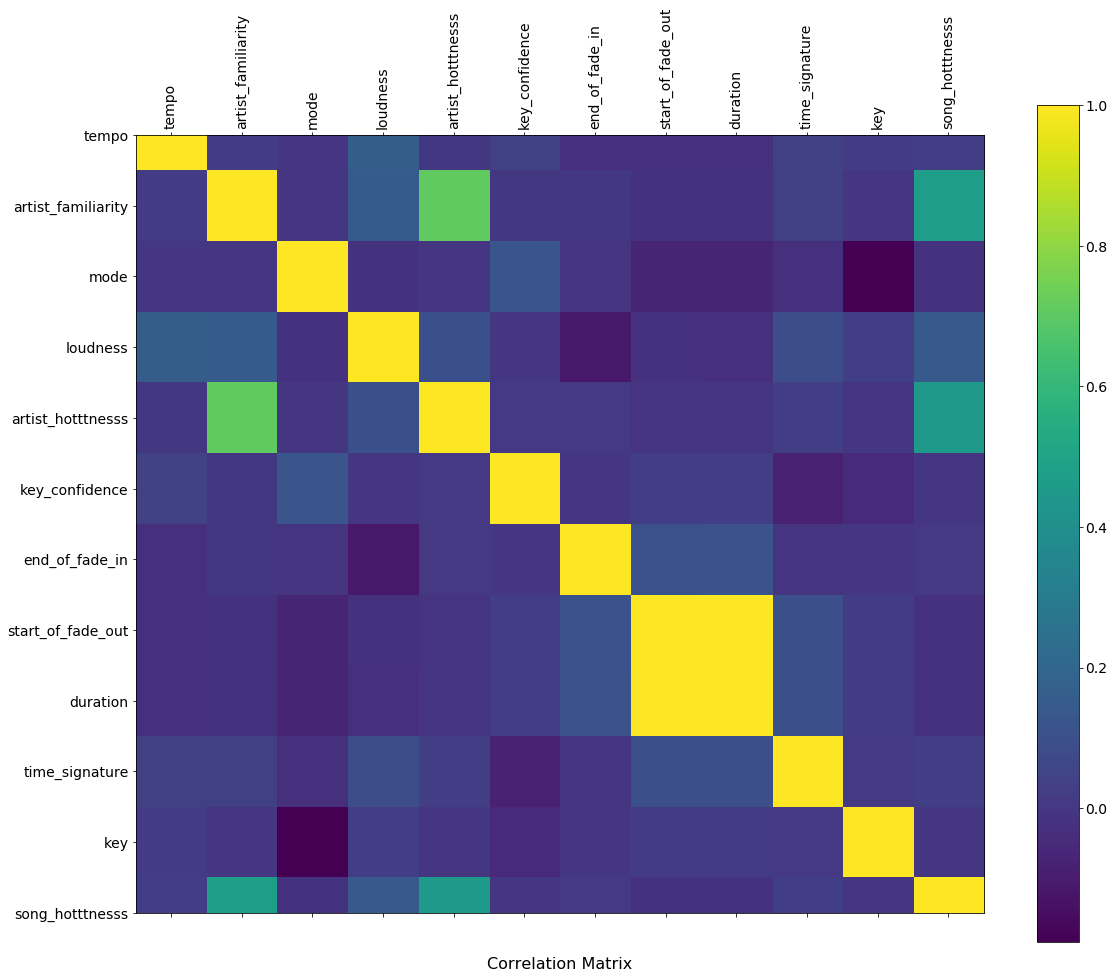

In [61]:
df = train_data[['tempo', 'artist_familiarity', 'mode', 'loudness', 'artist_hotttnesss', 'key_confidence', 'end_of_fade_in', 'start_of_fade_out', 'duration', 'time_signature', 'key', 'song_hotttnesss']]
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16, y=-0.08);
plt.show()

In [4]:
X = train_data[['tempo', 'artist_familiarity', 'mode', 'loudness', 'artist_hotttnesss', 'key_confidence', 'end_of_fade_in', 'start_of_fade_out', 'duration', 'time_signature', 'key']]
y = train_data[['song_hotttnesss']]
features = X.columns

In [5]:
#Label encoding - converting columns with non-numeric datatypes to numeric 
le = LabelEncoder()
for column in X.columns:
    if(X[column].dtype=='object'):
        print("Transforming column: ", collumn)
        X[column] = le.fit_transform(X[column])

In [6]:
X, y = X.values, y.values.flatten()
print(X.shape, y.shape)

(457194, 11) (457194,)


In [7]:
print(y.min(), y.mean(), y.max())

0.18764844599123687 0.453213974128351 1.0


### Centering our Data

In [8]:
cX = (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [9]:
# Now, we have our features in cX and labels in cY
# We will do a train test split
x_train, x_test, y_train, y_test = train_test_split(cX, y, test_size=0.33, random_state=42)

In [10]:
print("Train Samples:", x_train.shape)
print("Test Samples:", x_test.shape)

Train Samples: (306319, 11)
Test Samples: (150875, 11)


## Training Models

### Linear Regression

Train Score:  0.25677762661730086
Test Score:  0.25660726710832216
Root Mean squared error: 0.138672


<BarContainer object of 11 artists>

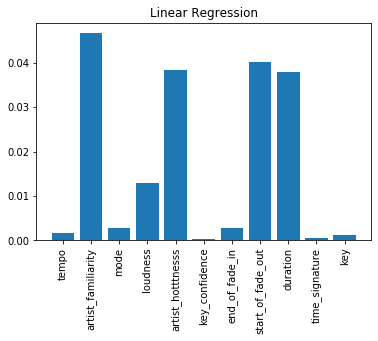

In [20]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Linear Regression")
plt.bar(features, np.abs(reg.coef_))

### Ridge Regression

Train Score:  0.25677762649149205
Test Score:  0.25660708428879786
Root Mean squared error: 0.138672


<BarContainer object of 11 artists>

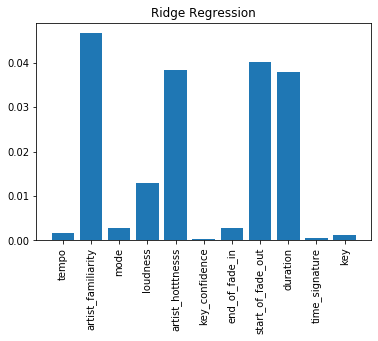

In [19]:
reg = linear_model.Ridge(alpha=0.5)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Ridge Regression")
plt.bar(features, np.abs(reg.coef_))

### Ridge Regression (Cross Validated)

Train Score:  0.2567775775234007
Test Score:  0.25660361759804107
Root Mean squared error: 0.138672
10.0


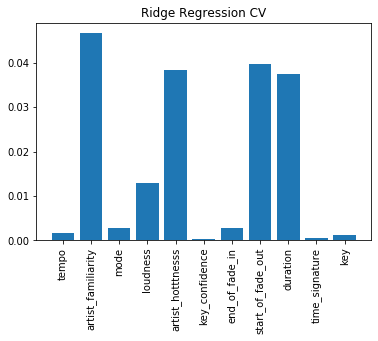

In [21]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Ridge Regression CV")
plt.bar(features, np.abs(reg.coef_))
print(reg.alpha_)

### Lasso Regression (Cross Validated)

Train Score:  0.25677762661730086
Test Score:  0.25660726710832227
Root Mean squared error: 0.138672
0.0


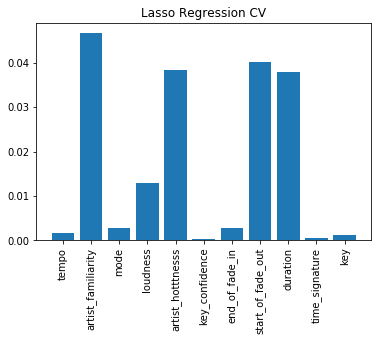

In [22]:
reg = linear_model.LassoLarsCV(cv=10)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Lasso Regression CV")
plt.bar(features, np.abs(reg.coef_))
print(reg.alpha_)

### Elastic Net

Train Score:  0.2565902624506613
Test Score:  0.256242597144819
Root Mean squared error: 0.138706


<BarContainer object of 11 artists>

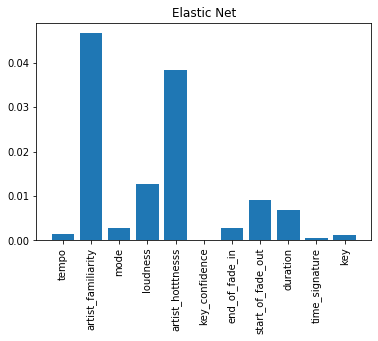

In [23]:
reg = linear_model.ElasticNetCV(cv=5, random_state=3)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Elastic Net")
plt.bar(features, np.abs(reg.coef_))

### Orthogonal Matching Pursuit

Train Score:  0.22155840217812206
Test Score:  0.21943179162000026
Root Mean squared error: 0.14


<BarContainer object of 11 artists>

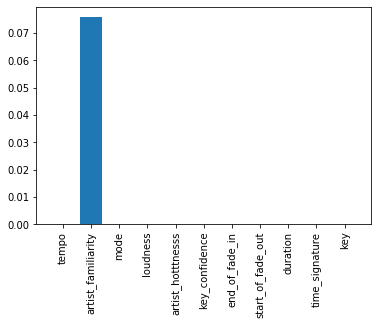

In [96]:
reg = linear_model.OrthogonalMatchingPursuit()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.2f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.bar(features, reg.coef_)

### Bayesian Ridge Regression

Train Score:  0.25677715564877834
Test Score:  0.25659570322868797
Root Mean squared error: 0.138673


<BarContainer object of 11 artists>

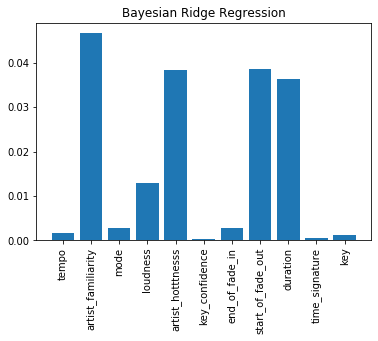

In [24]:
reg = linear_model.BayesianRidge()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Bayesian Ridge Regression")
plt.bar(features, np.abs(reg.coef_))

### Decision Trees

Train Score:  0.3228543124585418
Test Score:  0.3007638163143409
Root Mean squared error: 0.134490


<BarContainer object of 11 artists>

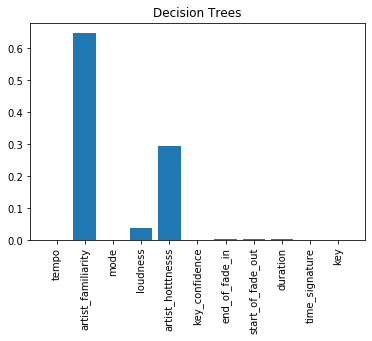

In [25]:
reg = tree.DecisionTreeRegressor(max_depth=10)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.title("Decision Trees")
plt.bar(features, reg.feature_importances_)

### Gradient Boost

In [27]:
reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=0, loss='ls')
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
print("Train Score: ", reg.score(x_train, y_train))
print("Test Score: ", reg.score(x_test, y_test))
print("Root Mean squared error: %.6f" % mean_squared_error(y_test, y_pred)**0.5)

Train Score:  0.446687135211165
Test Score:  0.3677844169492347
Root Mean squared error: 0.127883


<BarContainer object of 11 artists>

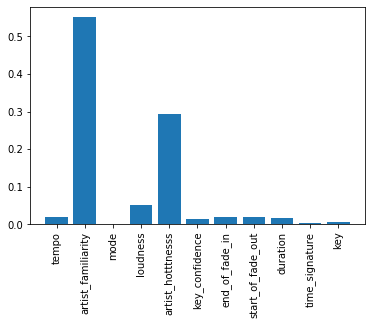

In [117]:
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.bar(features, reg.feature_importances_)

### XGBoost 

Root Mean squared error: 0.18


<BarContainer object of 11 artists>

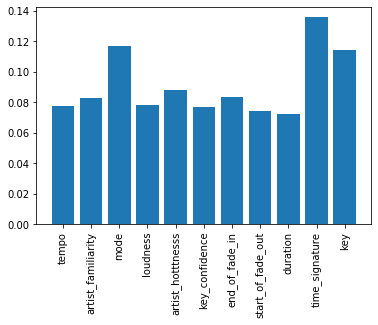

In [13]:
reg = XGBClassifier()
reg.fit(x_train[:1000], y_train[:1000])
y_pred = reg.predict(x_test[:100])
print("Root Mean squared error: %.2f" % mean_squared_error(y_test[:100], y_pred[:100])**0.5)
plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
plt.bar(features, reg.feature_importances_)

## Neural Networks

### Fully Connected Neural Network
2 Hidden Layers, Leaky ReLU activations

In [28]:
class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [29]:
net = Net(11, 100, 1)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.MSELoss()
x, y = Variable(torch.from_numpy(x_train).float()), Variable(torch.from_numpy(y_train).float().unsqueeze(1))

Training ...


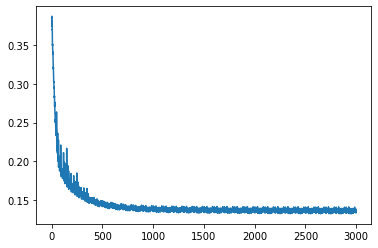

In [30]:
losses = []
print("Training ...")
N, D = x.shape
for iteration in range(30): 
    for epoch in range(100):
        optimizer.zero_grad()
        xb, yb = x[epoch*N//100:(epoch+1)*N//100], y[epoch*N//100:(epoch+1)*N//100]
        prediction = net(xb)
        loss = criterion(prediction, yb)
        loss.backward()         
        losses.append(loss.item()**0.5)
        optimizer.step()
plt.plot([i for i in range(len(losses))], losses)

In [42]:
xt, yt = Variable(torch.from_numpy(x_test).float()), Variable(torch.from_numpy(y_test).float().unsqueeze(1))
pred = net(xt)
loss = criterion(pred, yt)
print("Test R2 Score:", r2_score(yt.detach().numpy(), pred.detach().numpy()))
print("Test RMSE:", loss.item()**0.5)
pred = net(x)
loss = criterion(pred, y)
print("Train R2 Score:", r2_score(y_train, pred.detach().numpy()))
print("Train RMSE:", loss.item()**0.5)

Test R2 Score: 0.279620118748118
Test RMSE: 0.1365084324723699
Train R2 Score: 0.28217717371234285
Train RMSE: 0.13649858049250213
